In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# RNNs

### Recurrent Neurons and Layers

In feedforward networks, activation moves in one direction. In an RNN, it has connections pointing backwards. In a single neuron example it takes its own output as input. 

### Memory cells

The neurons dont generally have a long memory, but there are parts of the network that preserve state across time steps of the the RNN. 

### Input and Output Sequences

An RNN can take seq of inputs and produce seq of outputs, like predicting stock prices. This is called *sequence-to-sequence network*.

If can take a seq of inputs and ignore all outputs except for the last, as in predicting sentiment scores. This is called *sequence-to-vector network*.

Also, feed same input vector at each time step and let it ouput a seq, as in trying to get a caption for an image. This is *vector-to-seq network*.

Lastly, a seq-to-vec network called an *encoder* follwed by a vec-to-seq network called a *decoder*. Using it to translate a sentence to another language. Process looks like, feed network a sentence in one language, encoder converts sentence into vector representation, decoder decodes vector into seq in other language.

### Training RNN's

To train these, gotta unroll them through time (like in the diagrams) an then use backprop. Its called **drumroll** *backpropogation through time* (BPTT).

Like regular backprop, there is a foraward pass through the whole network, then the ouput sequence is measured using the cost function. It will backprop through the outputs that are being evaluated, updating the gradients through those outputs and across the network. Fig 15-5 and fig 15-4 on page 502 help with the visualizing.

## Forecasting Time Series

Generating a univariate series. A multivariate time series is a when there are multiple values per time step.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    #wave 1
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) 
    # + wave 2
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    # + noise
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

When dealing with time series, input features are usually represented as 3D arrays of shape [*batch size, time steps, dimensionality*]. In this case it will be one because univariate is just one dimension.

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

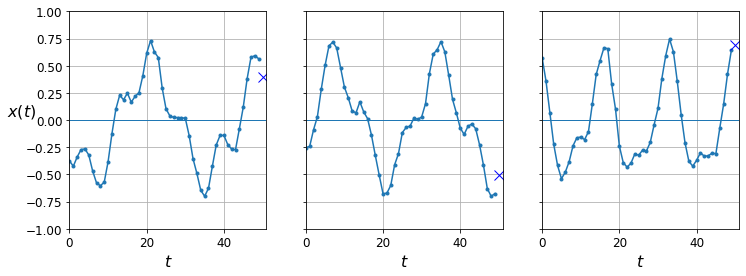

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$",
               y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize =10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0,0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows = 1 , ncols=3, sharey=True,
                        figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
               y_label=("$x(t)$" if col==0 else None))

plt.show()

### Computing Some Baselines

Naive predicting the last observed value

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

0.020211367

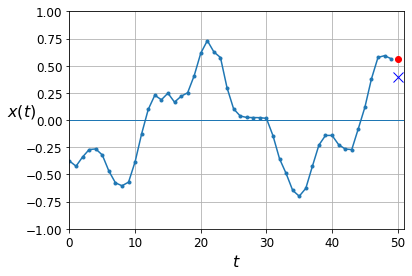

In [7]:
plot_series(X_valid[0,:, 0], y_valid[0,0], y_pred[0,0])
plt.show()

In [8]:
# Linear prediction

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087150901556

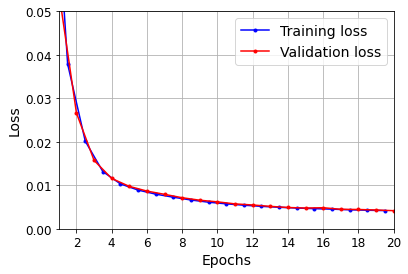

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1,20,0,0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Simple RNN

The `SimpleRNN` layer is one neuron. Don't need to specify the length of the input sequences because a RNN can process any number of time steps, which is why the first input dimension is `None`.

It defaults to hyperbbolic tangent activation.

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0116 - val_loss: 0.0110

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

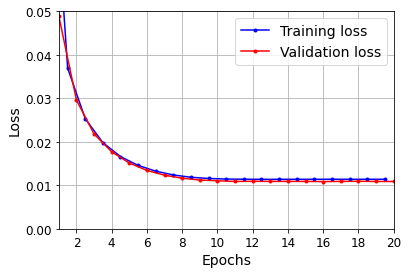

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

The simple linear model did better than the simple RNN. There were 51 parameters in the linear model above and only 3 in this RNN one. 

#### Trend and Seasonality

With models like *weighted moving averages* or *autoregressive integrated moving average* (ARIMA), you have to remove the trend and seasonality, and then add them back in for final predictions. But with RNN's its generally not necessary, but it can improve performance.

### Deep RNN's

Note: Make sure to set the `return_sequences=True` for all the recurrent layers or it will return a 2D array containing the output for the last time step instead of a 3D array of all outputs for the last time step. The next layer will complain as its expecting 3D format.

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0035 - val_lo

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0029


0.002910564187914133

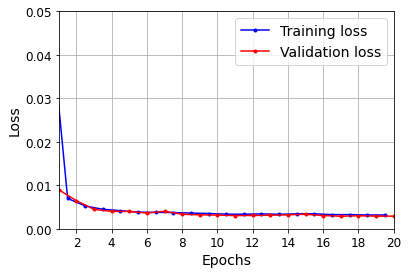

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

The last layer on the above model is not ideal. Dont really need the hidden state of that last neuron as the other ones will do it just as well. It also default uses the `tanh` activation, which has to have values between -1 and 1. Better to use a Dense layer as the final output layer, it will be slightly faster, accuracy will be similar and we get choice of activation function. 

Just got to make sure that dont `return_sequences=True` before the Dense layer.

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0030 - val_lo

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.002623623702675104

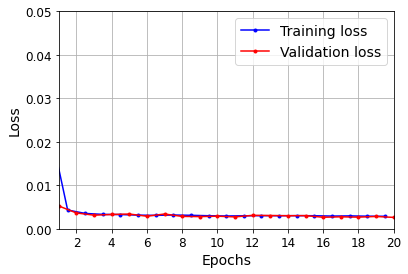

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Forecasting Several Steps

Next ten steps:

In [30]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [31]:
Y_pred.shape

(1, 10, 1)

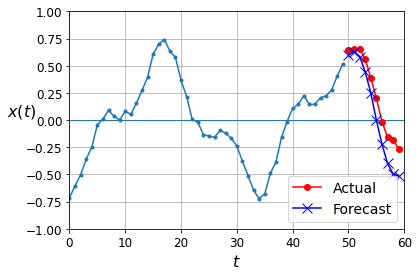

In [32]:
def plot_multiple_forecasts(X,Y,Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0,:,0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0,:,0],
            "ro-", label = "Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0],
            "bx-", label="Forecast", markersize=10)
    plt.axis([0,n_steps+ahead, -1,1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Using this to predict 10 next values:

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Predict next values one by one:

In [34]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:, 0]

In [35]:
y_pred.shape

(2000, 10)

In [39]:
np.mean(keras.metrics.mean_squared_error(Y_valid, y_pred))

0.027510857

Comparing against naive basline and simple linear baseline models:

In [40]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0222

Linear model still the best and fastest. All these were predicting the next value one at a time, taking a new prediction and using it as if its an input.

Now using an RNN to predict all 10 values at once, still using seq-to-vec model, using a Dense layer with 10 outputs:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0110 - val_lo

MSE is 0.0085

In [43]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[...,np.newaxis]

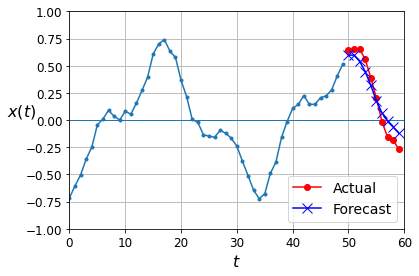

In [44]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [45]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [46]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

To turn the model into a seq-to-seq model, setting all return_sequences=True, even the last one, and have to apply the output Dense layer at every time step. 

`TimeDistributed` layer wraps the Dense layer and applies it at every time step of the input sequence. Reshapes the inputs so that each time step is a seperate instance ([*batch size, time steps, input dimensions] to [batch size x time steps, input dimensions]* and then back again).

Dont actually have to use this for Dense layer since it supports sequences as inputs.

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,
                          input_shape =[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01),
              metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                   validation_data= (X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0323 - last_time_step_mse: 0.0212 - val_loss: 0.0343 - val_last_time_step_mse: 0.0244
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0284 - val_last_time_step_mse: 0.0164
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0274 - last_time_step_mse: 0.0153 - val_loss: 0.0282 - val_last_time_step_mse: 0.0196
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0251 - last_time_step_mse: 0.0126 - val_loss: 0.0215 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/219 [==

The MSE is 0.006 which is better than the last model. 

You can combine the previous approach with this one. Predict 10 values and then concat them to input series and predict the 10 after that to an arbitrarily long seq. The model will suffer over long sequences however.

## Handling Long Sequences

### Dealing with Unstable Gradients

Many techniques used to deal with unstable gradients in deep feedforward networks can be used with deep RNN's like good parameter initialization, faster optimizers, dropout, but nonsaturiing activations like ReLu are more likely to make the RNN even more unstable.

Suppose gradient descent updates weights that increases weights during first time step, the same weights will be used at every time step and outputs will keep increasing, and ReLu wont stop that. Can avoid this by using a small lr or just sticking with the default tanh activation.

Will have to monitor them with Tensorboard and Gradient Clipping.

Batchnorm also not very efficient. Doesn't do anything for hidden states and minimal effect for inputs. Can add them but not going to do much.

Can use *Layer Normalization* for RNN's. Instead of normalizing across batch dimension, does it across features dimensions. 